In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
FEATURES_PREPPED_FILE = "features_prepped.csv"
TRAIN_TEST_SPLIT = 0.8
VAL_TEST_SPLIT = 0.5
START_DATE = datetime(2025,9,8) +timedelta(days=28)
BAD_FEATURES = ['avg_half_grade_2w_ago',
 'avg_price_2w_ago',
 'prev_2_half_grade',
 'avg_grade_co_BGS_1w_ago',
 'prev_1_half_grade',
 'index_change_1w',
 'avg_grade_co_PSA_1w_ago',
 'avg_half_grade_1w_ago',
 'prev_3_top_seller',
 'avg_top_seller_3w_ago',
 'prev_2_grade_co_BGS',
 'avg_grade_co_PSA_2w_ago',
 'prev_3_grade_co_BGS',
 'prev_2_top_seller',
 'prev_3_half_grade']

In [3]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
df

,date,spec_id,grade,half_grade,price,number_of_bids,top_seller,grade_co_BGS,grade_co_CGC,grade_co_PSA,...,avg_half_grade_4w_ago,avg_top_seller_4w_ago,avg_grade_co_BGS_4w_ago,avg_grade_co_CGC_4w_ago,avg_grade_co_PSA_4w_ago,index_value,index_change_1d,index_change_1w,index_ema_12,index_ema_26
37935,2025-10-06,2291755,10.0,0.0,112500,132,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,1.000000,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
213767,2025-10-06,14234253,10.0,1.0,14430,24,0,0,1,0,...,0.347339,0.016807,0.000000,0.540616,0.459384,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
116361,2025-10-06,8971913,10.0,1.0,8281,12,0,1,0,0,...,0.038462,0.000000,0.038462,0.076923,0.884615,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
116360,2025-10-06,8971913,10.0,0.0,5700,6,0,0,0,1,...,0.038462,0.000000,0.038462,0.076923,0.884615,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
213787,2025-10-06,14234253,10.0,1.0,13750,9,0,0,1,0,...,0.347339,0.016807,0.000000,0.540616,0.459384,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67274,2025-12-04,5009966,10.0,0.0,22500,27,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,1084.300207,23.889068,0.843726,1068.665258,1080.911953
157136,2025-12-04,12168705,10.0,0.0,21300,32,0,0,0,1,...,0.000000,0.625000,0.000000,0.000000,1.000000,1084.300207,23.889068,0.843726,1068.665258,1080.911953
132561,2025-12-04,9656727,9.0,0.0,47501,22,0,0,0,1,...,0.142857,0.523810,0.000000,0.190476,0.809524,1084.300207,23.889068,0.843726,1068.665258,1080.911953
163994,2025-12-04,12376814,10.0,0.0,8800,14,0,0,0,1,...,0.090909,0.545455,0.000000,0.363636,0.636364,1084.300207,23.889068,0.843726,1068.665258,1080.911953


In [4]:
feature_cols = [col for col in df.columns if col not in ['date', 'spec_id', 'price'] and col not in BAD_FEATURES]
feature_cols

['grade',
 'half_grade',
 'number_of_bids',
 'top_seller',
 'grade_co_BGS',
 'grade_co_CGC',
 'grade_co_PSA',
 'prev_1_price',
 'prev_1_grade_co_BGS',
 'prev_1_grade_co_CGC',
 'prev_1_grade_co_PSA',
 'prev_1_top_seller',
 'prev_1_days_ago',
 'prev_2_price',
 'prev_2_grade_co_CGC',
 'prev_2_grade_co_PSA',
 'prev_2_days_ago',
 'prev_3_price',
 'prev_3_grade_co_CGC',
 'prev_3_grade_co_PSA',
 'prev_3_days_ago',
 'avg_price_1w_ago',
 'avg_top_seller_1w_ago',
 'avg_grade_co_CGC_1w_ago',
 'avg_top_seller_2w_ago',
 'avg_grade_co_BGS_2w_ago',
 'avg_grade_co_CGC_2w_ago',
 'avg_price_3w_ago',
 'avg_half_grade_3w_ago',
 'avg_grade_co_BGS_3w_ago',
 'avg_grade_co_CGC_3w_ago',
 'avg_grade_co_PSA_3w_ago',
 'avg_price_4w_ago',
 'avg_half_grade_4w_ago',
 'avg_top_seller_4w_ago',
 'avg_grade_co_BGS_4w_ago',
 'avg_grade_co_CGC_4w_ago',
 'avg_grade_co_PSA_4w_ago',
 'index_value',
 'index_change_1d',
 'index_ema_12',
 'index_ema_26']

In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

In [6]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")


Training set: 107325 samples
Validation set: 13416 samples
Number of features: 42


In [ ]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10, 12, 15, 20],
    'learning_rate': [0.05, 0.075, 0.1, 0.15, 0.2],
    'n_estimators': [10, 20, 50, 100],
    'min_child_weight': [5, 7, 10, 20],
    'subsample': [0.75, 0.8, 0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2, 5],
    'colsample_bylevel': [0.7, 0.8, 1.0],
    'max_delta_step': [0, 1, 5],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train,y_train)
    y_val_pred = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print ("Best MAPE: %0.5f" % best_score )
print ("Best Grid:", best_grid)

/root/sync/ava/collector_crypt/.venv/lib/python3.14/site-packages/xgboost/core.py:774: UserWarning: [14:22:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


MAPE: 217.80%
Best MAPE: 217.80%
MAPE: 217.78%
Best MAPE: 217.78%
MAPE: 217.87%
Best MAPE: 217.78%
MAPE: 217.75%
Best MAPE: 217.75%
MAPE: 217.84%
Best MAPE: 217.75%
MAPE: 217.87%
Best MAPE: 217.75%
MAPE: 217.78%
Best MAPE: 217.75%
MAPE: 217.83%
Best MAPE: 217.75%
MAPE: 217.82%
Best MAPE: 217.75%
MAPE: 217.83%
Best MAPE: 217.75%
MAPE: 217.83%
Best MAPE: 217.75%
MAPE: 217.70%
Best MAPE: 217.70%
MAPE: 217.80%
Best MAPE: 217.70%
MAPE: 217.78%
Best MAPE: 217.70%
MAPE: 217.87%
Best MAPE: 217.70%
MAPE: 217.75%
Best MAPE: 217.70%
MAPE: 217.84%
Best MAPE: 217.70%
MAPE: 217.87%
Best MAPE: 217.70%
MAPE: 217.78%
Best MAPE: 217.70%
MAPE: 217.83%
Best MAPE: 217.70%
MAPE: 217.82%
Best MAPE: 217.70%
MAPE: 217.83%
Best MAPE: 217.70%
MAPE: 217.83%
Best MAPE: 217.70%
MAPE: 217.70%
Best MAPE: 217.70%
MAPE: 217.80%
Best MAPE: 217.70%
MAPE: 217.78%
Best MAPE: 217.70%
MAPE: 217.87%
Best MAPE: 217.70%
MAPE: 217.75%
Best MAPE: 217.70%
MAPE: 217.84%
Best MAPE: 217.70%
MAPE: 217.87%
Best MAPE: 217.70%
MAPE: 217.

In [ ]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_test_pred = best_model.predict(X_test)

val_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_mae = mean_absolute_error(y_test, y_test_pred)
val_mape = mean_absolute_percentage_error(y_test, y_test_pred)
val_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
# Percent error (signed, not absolute)
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))


Validation Metrics:
  RMSE: $40,916.21
  MAE:  $8,353.69
  MAPE: 30.72%
  R²:   0.7752

Simple Percent Error Percentiles:
count    13416.000000
mean        34.088295
std        398.018198
min          0.000000
10%          1.760368
20%          4.086022
30%          7.042254
40%         10.377358
50%         14.728453
60%         20.000000
70%         27.586207
80%         39.610390
90%         61.895004
max      41543.835616
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    13416.000000
mean        30.723097
std        197.283365
min          0.002940
10%          2.260232
20%          4.744103
30%          7.459664
40%         10.525237
50%         14.124574
60%         18.693224
70%         24.987303
80%         35.744519
90%         59.112721
max      18968.922158
Name: percent_error, dtype: float64


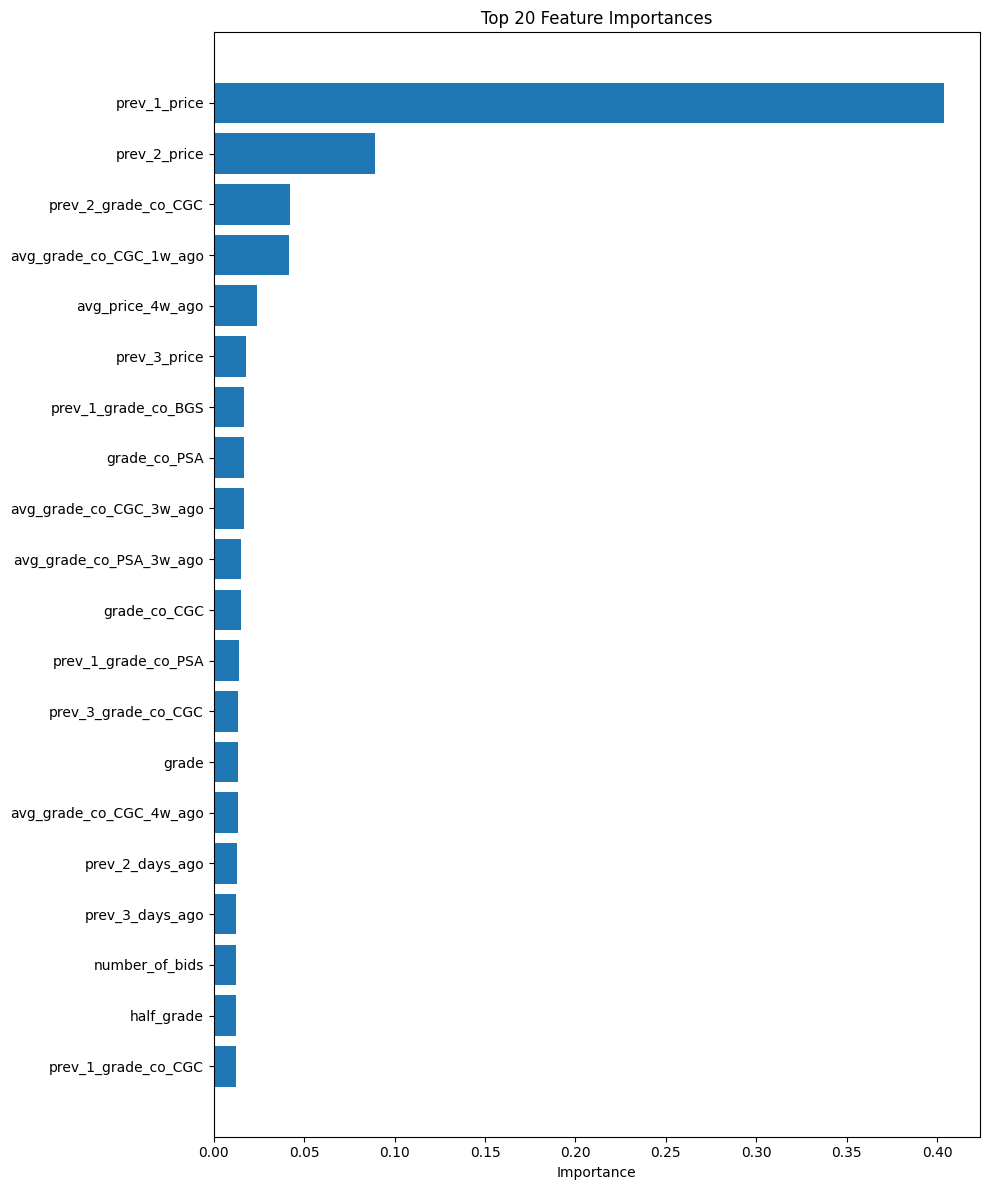

In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()

In [ ]:
importance_df
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['avg_grade_co_BGS_4w_ago',
 'avg_price_1w_ago',
 'avg_price_3w_ago',
 'avg_grade_co_BGS_3w_ago',
 'prev_1_top_seller',
 'top_seller',
 'avg_grade_co_CGC_2w_ago',
 'avg_top_seller_4w_ago']